In [9]:
import pandas as pd
import numpy as np
from helpers import *
import ast
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# # Set up the plot style
# plt.style.use('seaborn')
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# fig.suptitle('Trading Strategy Analysis', fontsize=16)

warnings.filterwarnings("ignore")

In [10]:
years = ['twenty2','twenty3','twenty4']
strategies = [
    'CDvDIFFC_2H',
            'CDvDIFFP_2H',
              ]
week_dfs = []

for year in years:
    year_data = YEAR_CONFIG[year]
    for file_name in year_data['all_files']:
        for strategy in strategies:
            try:
                week_df = pd.read_csv(f"/Users/charlesmiller/Documents/backtesting_data/TREND55-ALLSEV/{strategy}/{file_name}.csv")
                week_dfs.append(week_df)
            except FileNotFoundError:
                print(f"File {file_name} not found")
                continue

all_data = pd.concat(week_dfs)


File 2024-07-01 not found
File 2024-07-01 not found
File 2024-07-08 not found
File 2024-07-08 not found
File 2024-07-15 not found
File 2024-07-15 not found
File 2024-07-22 not found
File 2024-07-22 not found
File 2024-07-29 not found
File 2024-07-29 not found
File 2024-08-05 not found
File 2024-08-05 not found
File 2024-08-12 not found
File 2024-08-12 not found
File 2024-08-19 not found
File 2024-08-19 not found
File 2024-08-26 not found
File 2024-08-26 not found
File 2024-09-02 not found
File 2024-09-02 not found
File 2024-09-09 not found
File 2024-09-09 not found
File 2024-09-16 not found
File 2024-09-16 not found
File 2024-09-23 not found
File 2024-09-23 not found
File 2024-09-30 not found
File 2024-09-30 not found
File 2024-10-07 not found
File 2024-10-07 not found
File 2024-10-14 not found
File 2024-10-14 not found
File 2024-10-21 not found
File 2024-10-21 not found
File 2024-10-28 not found
File 2024-10-28 not found
File 2024-11-04 not found
File 2024-11-04 not found
File 2024-11

In [11]:
def build_contract_df(row):
    contract = ast.literal_eval(row['contracts'])
    last_price = get_last_price(row)
    row['alert_price'] = last_price
    if len(contract) == 0:
        return pd.DataFrame()
    ## turn a list into a df
    contract_df = pd.DataFrame(contract)
    contract_df.rename(columns={0:'contract_name'}, inplace=True)
    contract_df[['strike','expiry']] = contract_df['contract_name'].apply(lambda x: extract_strike_price(x,row['side']))
    ## find index of the contract with the strike price greater than row['alert_price']
    expiries = ast.literal_eval(row['expiries'])
    contract_dfs = []
    for expiry in expiries:
        expiry_df = contract_df[contract_df['expiry'] == expiry].reset_index(drop=True)
        if row['side'] == 'C':
            select_contracts = expiry_df[expiry_df['strike'] > row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=True, inplace=True)
        elif row['side'] == 'P':
            select_contracts = expiry_df[expiry_df['strike'] < row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=False, inplace=True)
        idx_break = select_contracts.index[0]
        select_contracts = expiry_df.iloc[(idx_break-1):(idx_break+4)]
        # if len(select_contracts) < 5:
        #     print(contract_df)
        #     print(expiry_df)
        #     print(expiry)
        #     print(row['alert_price'])   
        contract_dfs.append(select_contracts)
    for contract_df in contract_dfs:
        # print("LEN CONTRACT DF 3", len(contract_df))
        try:
            contract_df[["max_price","min_price","max_time_diff","min_time_diff","open_price","median_price_appreication"]] = contract_df.apply(lambda x: calculate_contract_price_statistics(x,row), axis=1, result_type='expand')
            contract_df['max_appreciation'] = (contract_df['max_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['max_depreciation'] = (contract_df['min_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['strategy'] = row['strategy']
            contract_df['side'] = row['side']
            contract_df['probability'] = row['probabilities']
            contract_df['label'] = row['label']
            contract_df['date'] = row['dt']
            contract_df['hour'] = row['hour']
            contract_df['minute'] = row['minute']
            contract_df.reset_index(drop=True, inplace=True)
            contract_df['spread_position'] = contract_df.index
        except Exception as e:
            # print(e)
            # print(contract_df)
            # print(row)
            # print()
            continue
    full_contract_df = pd.concat(contract_dfs)
    return full_contract_df

def categorize_week(row):
    if row['symbol'] in ['SPY','QQQ','IWM']:
        if row['day_of_week'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    if row['day_of_week'] == 'Monday':
        if row['days_to_expiry'] == 4:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Tuesday':
        if row['days_to_expiry'] == 3:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Wednesday':
        if row['days_to_expiry'] == 2:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Thursday':
        if row['days_to_expiry'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Friday':
        if row['days_to_expiry'] == 0:
            return 'wk0'
        elif row['days_to_expiry'] == 7:
            return 'wk1'
        else:
            return 'wk2'
    
    

In [12]:
option_price_analytics_dfs =[]
for idx, row in all_data.iterrows():
    try:
        contract_df = build_contract_df(row)
        option_price_analytics_dfs.append(contract_df)
    except Exception as e:
        print(e)
        print(row['symbol'])
        print(idx)
        print()
        continue

index 0 is out of bounds for axis 0 with size 0
META
152

index 0 is out of bounds for axis 0 with size 0
META
154

index 0 is out of bounds for axis 0 with size 0
QQQ
30

index 0 is out of bounds for axis 0 with size 0
SPY
31

index 0 is out of bounds for axis 0 with size 0
QQQ
33

index 0 is out of bounds for axis 0 with size 0
SPY
34

index 0 is out of bounds for axis 0 with size 0
QQQ
35

index 0 is out of bounds for axis 0 with size 0
SPY
36

index 0 is out of bounds for axis 0 with size 0
QQQ
37

index 0 is out of bounds for axis 0 with size 0
SPY
38

index 0 is out of bounds for axis 0 with size 0
TSM
39

index 0 is out of bounds for axis 0 with size 0
META
40

index 0 is out of bounds for axis 0 with size 0
TSM
43

index 0 is out of bounds for axis 0 with size 0
META
29

index 0 is out of bounds for axis 0 with size 0
SPY
34

index 0 is out of bounds for axis 0 with size 0
META
35

index 0 is out of bounds for axis 0 with size 0
QQQ
40

index 0 is out of bounds for axis 0 with 

KeyboardInterrupt: 

In [ ]:
fopa = pd.concat(option_price_analytics_dfs)

In [ ]:
fopa.to_csv("option_price_analytics_vDIFF.csv", index=False)

In [ ]:
fopa["contract_time"] = fopa["date"].apply(lambda x: pd.to_datetime(x).strftime('%y%m%d'))
fopa['days_to_expiry'] = (pd.to_datetime(fopa["expiry"], format='%y%m%d') - (pd.to_datetime(fopa["contract_time"], format='%y%m%d')))
fopa['days_to_expiry'] = fopa['days_to_expiry'].dt.days
fopa['day_of_week'] = pd.to_datetime(fopa['date']).dt.day_name()
fopa['exp_week'] = fopa.apply(lambda x: categorize_week(x), axis=1)
fopa['symbol'] = fopa['contract_name'].apply(lambda x: x[2:-15])


ValueError: NaTType does not support strftime

In [ ]:
fopa.iloc[1]

contract_name       O:TSM220107C00127000
strike                             127.0
expiry                            220107
max_price                            3.3
min_price                           1.37
max_time_diff                       30.0
min_time_diff                        0.0
open_price                          1.37
max_appreciation                     2.3
max_depreciation                    0.37
strategy                     CDvDIFFC_2H
side                                   C
probability                     0.589771
label                                  1
date                          2022-01-03
hour                                  10
minute                                 0
contract_time                     220103
days_to_expiry                         4
day_of_week                       Monday
exp_week                             wk0
symbol                               TSM
Name: 1, dtype: object

In [ ]:
fopa['max_appreciation'].describe()

count    71740.000000
mean         2.615374
std          4.953790
min         -0.990000
25%         -0.290000
50%          1.000000
75%          3.530000
max         79.860000
Name: max_appreciation, dtype: float64

In [ ]:
fopa.loc[fopa['label']== 1]['max_appreciation'].describe()

count    45702.000000
mean         2.735880
std          4.793437
min         -0.990000
25%         -0.220000
50%          1.110000
75%          3.720000
max         57.050000
Name: max_appreciation, dtype: float64

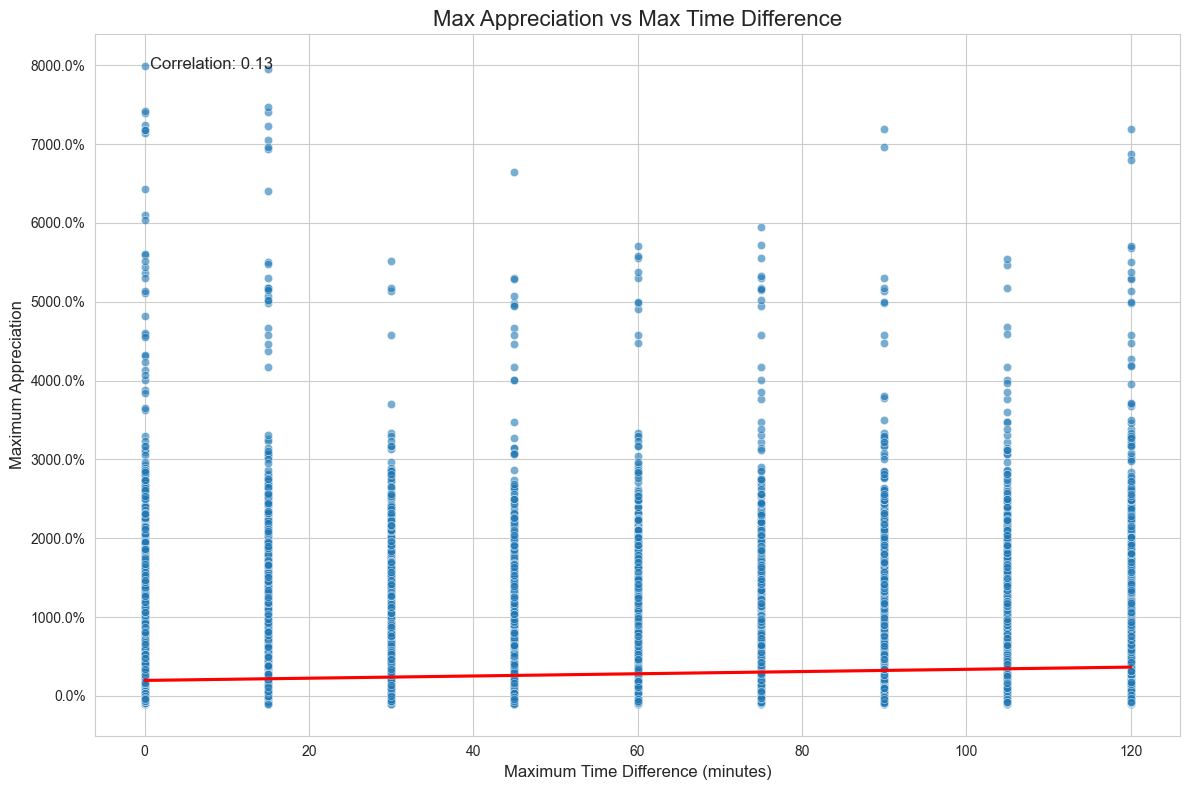

In [ ]:
fopa.reset_index(drop=True, inplace=True)
# Set the style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    alpha=0.6
)

# Add a trend line
sns.regplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    scatter=False,
    color='red'
)

# Customize the plot
plt.title('Max Appreciation vs Max Time Difference', fontsize=16)
plt.xlabel('Maximum Time Difference (minutes)', fontsize=12)
plt.ylabel('Maximum Appreciation', fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add text for correlation
correlation = fopa['max_time_diff'].corr(fopa['max_appreciation'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0)].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,7919.0,2.987553,4.516765,-0.99,0.160,1.42,4.00,37.99
Monday,5939.0,3.539800,4.943947,-0.99,0.260,1.85,4.98,30.00
Thursday,9169.0,2.550643,5.377754,-0.99,-0.440,0.77,3.15,57.05
Tuesday,6975.0,2.906862,4.593627,-0.99,0.015,1.35,4.00,31.65
Wednesday,6650.0,3.145180,5.004551,-0.99,-0.180,1.30,4.65,38.52


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk0')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Monday,2564.0,2.934949,4.585201,-0.98,0.0200,1.26,4.060,28.20
Thursday,3848.0,1.557555,4.273676,-0.99,-0.6600,0.17,1.850,56.85
Tuesday,2840.0,2.143722,4.137462,-0.99,-0.2725,0.76,2.800,28.60
Wednesday,2651.0,2.128050,4.271474,-0.99,-0.4100,0.62,2.955,37.70


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk1')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,4411.0,2.653890,4.397922,-0.99,-0.15,1.07,3.59,37.80
Monday,3375.0,3.999307,5.153394,-0.99,0.56,2.25,5.59,30.00
Thursday,5321.0,3.268818,5.949955,-0.99,-0.10,1.30,4.07,57.05
Tuesday,4135.0,3.431001,4.813192,-0.99,0.33,1.86,4.76,31.65
Wednesday,3999.0,3.819452,5.330884,-0.99,0.10,1.86,5.80,38.52


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk2')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,3508.0,3.407104,4.628511,-0.98,0.56,1.81,4.4,37.99


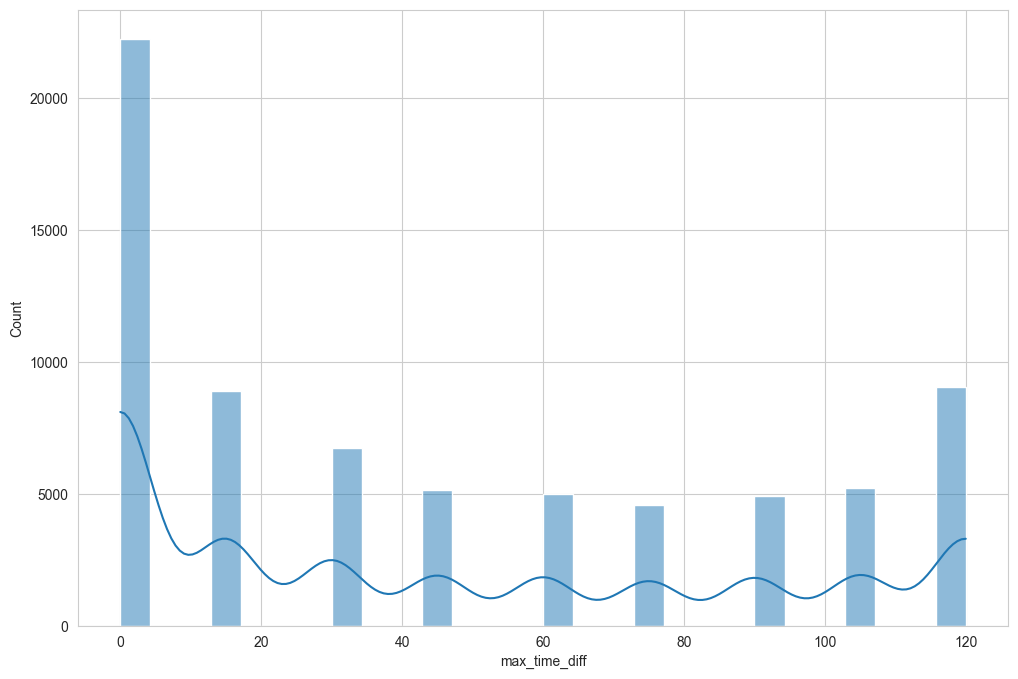

In [ ]:
## create a histogram of the max_time_diff
plt.figure(figsize=(12, 8))
hist = sns.histplot(
    data=fopa,
    x='max_time_diff',
    kde=True
)
# result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_time_diff'].describe()


In [ ]:
result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,10072.0,1.970981,3.777394,-0.99,-0.27,0.690,2.5725,31.65
Monday,7343.0,2.437313,4.274183,-0.99,-0.22,0.980,3.2500,28.77
Thursday,11219.0,1.351172,4.730373,-0.99,-0.83,-0.160,1.3400,56.99
Tuesday,8598.0,1.863590,4.008398,-0.99,-0.48,0.505,2.4000,30.89
Wednesday,8470.0,1.846792,4.150369,-0.99,-0.65,0.300,2.5000,34.09


In [ ]:
result = fopa[fopa['label'] == 1].groupby(['day_of_week','symbol','exp_week'])['max_appreciation'].describe()
result.to_csv('symbol_dow_apprc_vdiff.csv')

In [ ]:
result = fopa[fopa['label'] == 0].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,4792.0,2.955388,5.671693,-0.99,0.1200,1.36,3.77,74.23
Monday,4640.0,2.641642,5.572964,-0.99,-0.2325,1.04,3.65,79.86
Thursday,6465.0,2.043555,5.863547,-0.99,-0.7400,0.20,2.15,55.20
Tuesday,5129.0,2.285531,3.989240,-0.99,-0.3000,1.02,3.50,46.80
Wednesday,5012.0,2.242273,4.550679,-0.99,-0.5100,0.73,3.10,37.00


In [ ]:
result = fopa[fopa['label'] == 0].groupby('day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,4792.0,2.238719,5.272976,-0.99,-0.23,0.77,2.80,74.22
Monday,4640.0,1.977916,5.243617,-0.99,-0.51,0.44,2.50,74.80
Thursday,6465.0,1.379918,5.539866,-0.99,-0.89,-0.34,1.07,51.78
Tuesday,5129.0,1.615143,3.675910,-0.99,-0.59,0.37,2.39,44.50
Wednesday,5012.0,1.519771,4.130826,-0.99,-0.74,0.07,1.90,32.65
